In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

In [2]:
# Define a function to change the MNIST label dimension
def change_to_right(wrong_labels):
    right_labels=[]
    for x in wrong_labels:
        for i in range(0,len(wrong_labels[0])):
            if x[i]==1:
                right_labels.append(i)
    return right_labels

# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Convert class vectors to right format
y_train = tf.convert_to_tensor(np.array(change_to_right(keras.utils.to_categorical(y_train, num_classes))))
y_test = tf.convert_to_tensor(np.array(change_to_right(keras.utils.to_categorical(y_test, num_classes))))

In [3]:
image_size = 28  # We'll resize input images to this size
patch_size = 14  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 96
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 16
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [4]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.Normalization(),
        #layers.Resizing(image_size, image_size),
        #layers.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
        tf.keras.layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [5]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = inputs #data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

##### tf2.4.0: https://docs.w3cub.com/tensorflow~2.4/keras/optimizers/adamax

In [7]:
def run_experiment(model):
    
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)
    
    optimizer = tf.keras.optimizers.Adam(lr_schedule)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "./tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    
    batch_size = 2000
    num_epochs = 5
    
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

model_vit = create_vit_classifier()
history = run_experiment(model_vit)

Epoch 1/5
27/27 [==============================] - 154s 5s/step - loss: 1.8277 - accuracy: 0.4197 - top-5-accuracy: 0.7971 - val_loss: 0.2655 - val_accuracy: 0.9163 - val_top-5-accuracy: 0.9960
Epoch 2/5
27/27 [==============================] - 151s 6s/step - loss: 0.3778 - accuracy: 0.8838 - top-5-accuracy: 0.9928 - val_loss: 0.1482 - val_accuracy: 0.9578 - val_top-5-accuracy: 0.9980
Epoch 3/5
27/27 [==============================] - 164s 6s/step - loss: 0.2190 - accuracy: 0.9334 - top-5-accuracy: 0.9969 - val_loss: 0.1094 - val_accuracy: 0.9692 - val_top-5-accuracy: 0.9982
Epoch 4/5
27/27 [==============================] - 150s 6s/step - loss: 0.1572 - accuracy: 0.9513 - top-5-accuracy: 0.9983 - val_loss: 0.0888 - val_accuracy: 0.9762 - val_top-5-accuracy: 0.9985
Epoch 5/5
313/313 [==============================] - 13s 35ms/step - loss: 0.0969 - accuracy: 0.9712 - top-5-accuracy: 0.9995
Test accuracy: 97.12%
Test top 5 accuracy: 99.95%


In [8]:
model_vit.evaluate(x_test, y_test)

313/313 [==============================] - 11s 34ms/step - loss: 0.0969 - accuracy: 0.9712 - top-5-accuracy: 0.9995 3s - loss: 0.1


[0.09692513942718506, 0.9711999893188477, 0.9994999766349792]

In [9]:
prediction = model_vit.predict(x_test[:,:,:,0])

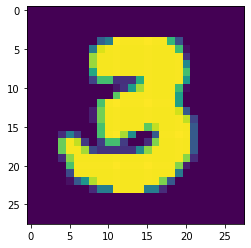

Prediction: 3


In [16]:
pred_img_num = 200
image = np.squeeze(x_test[pred_img_num,:,:,0])
plt.imshow(image)
plt.show()

print("Prediction:", np.argmax(prediction[pred_img_num,:]))